Please do one of the following.


# Part I: Classification

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [120]:
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import DecisionTreeRegressor

In [121]:
#load the dataset
df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [122]:
df_default=pd.get_dummies(df['default'])
df_student=pd.get_dummies(df['student'])
df_concat = pd.concat([df_default,df_student,df[['balance','income']],],axis=1)
df_final = df_concat.drop(df_concat.columns[[0,2]],axis=1)
df_final.columns = ['default',  'student', 'balance','income']
df_final.head()

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

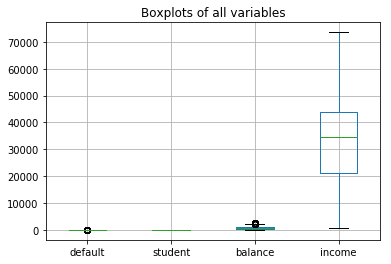

In [123]:
# Boxplots of all variables
df_final.boxplot()
plt.title('Boxplots of all variables')
plt.show()

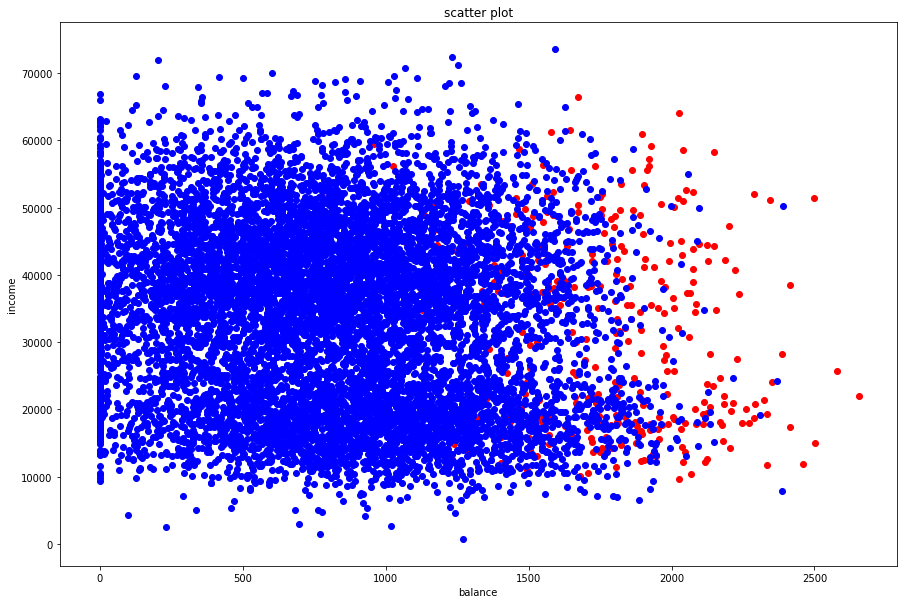

In [124]:
# Scatter plots
yes = df_final.loc[df_final['default']==0,'balance':]
no = df_final.loc[df_final['default']==1,'balance':]
plt.figure(figsize=(15,10))
plt.scatter(no.balance,no.income,color='r')
plt.scatter(yes.balance,yes.income,color='b')
plt.xlabel('balance')
plt.ylabel('income')
plt.title('scatter plot')
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

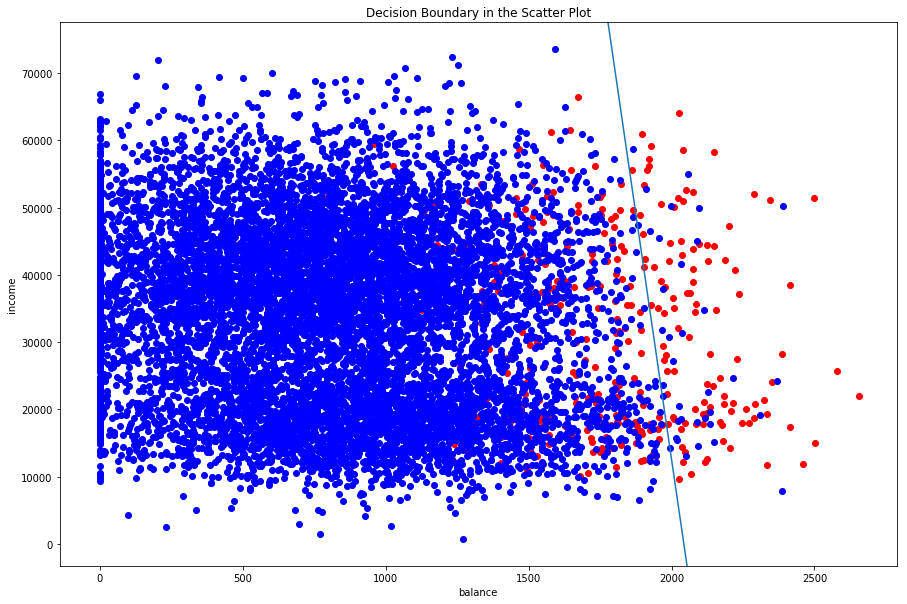

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X = df_final[["balance", "income"]]
y = df_final["default"]

#Training a model
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)
coef = clf.coef_

#Plot the decision boundary in the scatter
plt.figure(figsize=(15,10))
plt.scatter(no.balance,no.income,color='r')
plt.scatter(yes.balance,yes.income,color='b')
plt.xlabel('balance')
plt.ylabel('income')

b = clf.intercept_
w = clf.coef_[0]
axes = plt.gca()
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()

x = np.arange(xmin, xmax, 1)
y = (b + w[0] * x) / -w[1]

plt.plot(x, y)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title('Decision Boundary in the Scatter Plot')
plt.show()

Area under the ROC curve : 0.960663


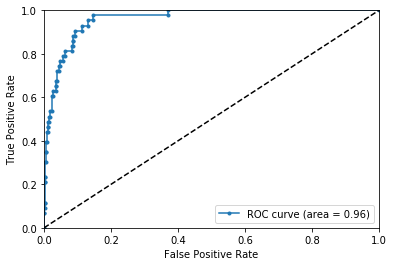

In [126]:
#Compute AUC ROC
X = df_final[['balance','income']]
y = df_final['default']
def generate_auc(X,y,clf_class,**kwargs):
    random_state = np.random.RandomState(0)
    # training set and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Building up a Generating ROC Function
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    fig = plt.figure()
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

8.64842327573
Area under the ROC curve : 0.962267


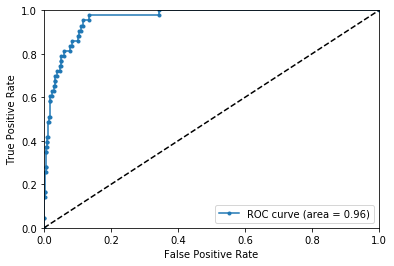

In [127]:
from sklearn.linear_model import Ridge
X = df_final[['student','balance','income']]
y = df_final['default']

scaler = StandardScaler()
X = X.as_matrix().astype(np.float)
X = scaler.fit_transform(X)
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)
                                                  
# Ridge regression
alphas = np.logspace(-8,1,1000)
train_errors = list()
test_errors = list()
for alpha in alphas:
    logreg = LogisticRegression(C=alpha,penalty='l2') 
    logreg.fit(X_train, y_train)
   
    probas_ = logreg.predict_proba(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    train_errors.append(roc_auc)
    
    probas_ = logreg.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    test_errors.append(roc_auc)

i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]
print(alpha_optim)

plt.figure(figsize=(10,5))
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=alpha_optim,penalty='l2')
generate_ROCplot(fpr,tpr,'LR',roc_auc)

plt.show()

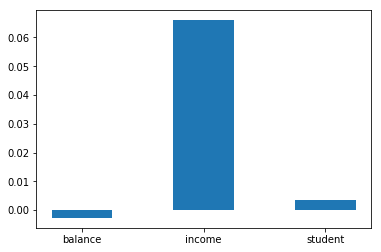

[-0.00271491  0.065993    0.00335115]


In [128]:
ridgereg = Ridge(alpha= alpha_optim)
ridgereg.fit(X_train,y_train)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(3), ridgereg.coef_, 0.5)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('balance', 'income', 'student'))

plt.show()
print (ridgereg.coef_)

In [129]:
# With the optimal alpha, the area under ROC curve increases from 0.960 to 0.962 after adding student variable, which indicates
# this variable doed not influence the result too much.

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

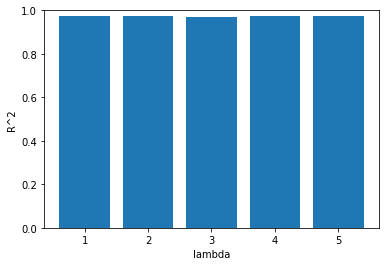

[ 0.97551224  0.97351324  0.971       0.97248624  0.97348674]


In [130]:
from sklearn.model_selection import cross_val_score

regr = LogisticRegression(C = alpha_optim, penalty = 'l2')
scores = cross_val_score(regr, X, y, cv=5)
plt.ylim([0,1])
plt.xlabel('lambda')
plt.ylabel('R^2')
plt.bar(range(1,6),scores)
plt.show()

print(scores)
# It can be seen that this model is robust.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [138]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")


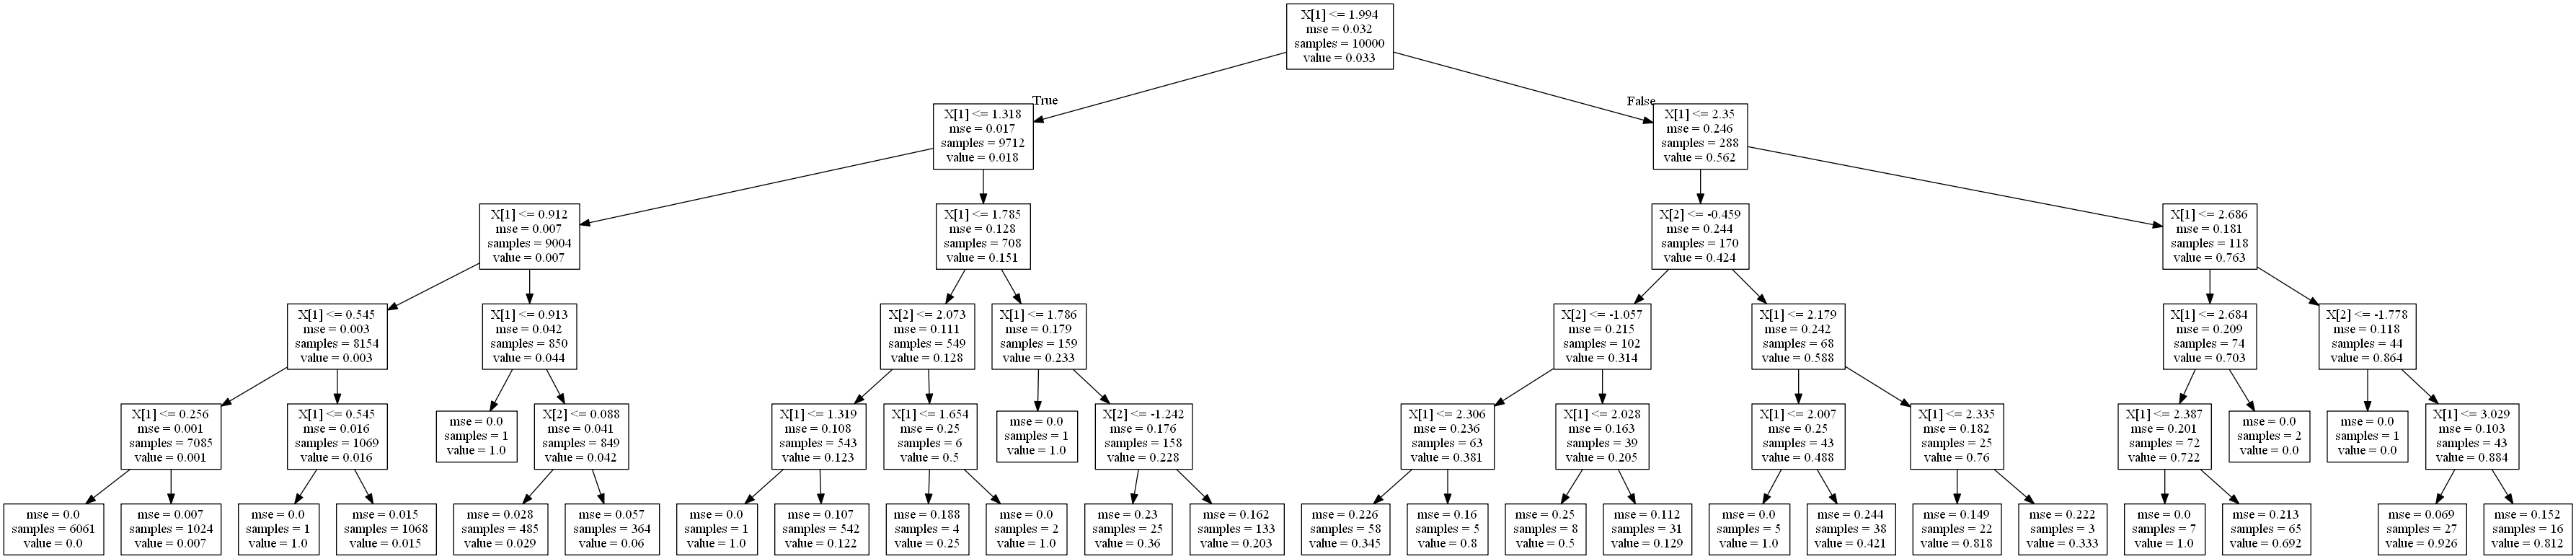

In [139]:
#plot the tree
regr_5 = DecisionTreeRegressor(max_depth=5)
regr_5.fit(X, y)
dt=DecisionTreeRegressor(max_depth=5)
visualize_tree(regr_5, feature_names=['x'])
dot_data=export_graphviz(regr_5, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Area under the ROC curve : 0.932280


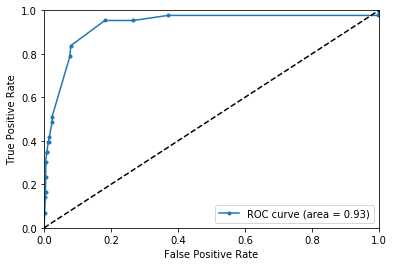

In [137]:
plt.figure(figsize=(10,15))
y = df_final['default']
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth=5)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

In [ ]:
# For the decision, the depth is 5. Under this condition, the area under ROC curve is 0.93 which is less than 0.96. Ridge model would be better than this.

8) Find the optimal decision tree depth and compute the AUC ROC. 

2


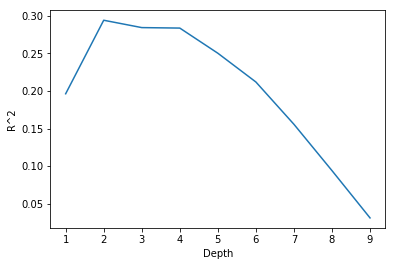

In [135]:
# Fit regression model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,10)
for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
best_depth=depths[np.argmax(scores)]
print(best_depth)
plt.show()

Area under the ROC curve : 0.951562


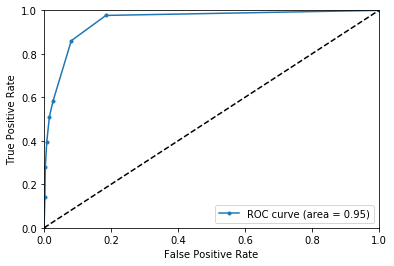

In [136]:
# Calculate AUC ROC and plot roc
fpr,tpr,roc_auc,thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth=n_opt)
generate_ROCplot(fpr,tpr,'LR',roc_auc)